In [42]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU')) # check if GPU is enabled

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [43]:
# please take note that this notebook is written in WSL2 for the support of tensorflow.
# It is propablity easier to run this notebook in Linux, I guess.
# For MacOS users, please be aware that it does not have offical GPU support.
# below is all the packages needed
# help('modules') # unmark this if needed (it is quite slow)

In [44]:
# below is the python version infomation
import sys
print(sys.version)

3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]


In [45]:
# cuda and cnn info
from tensorflow.python.platform import build_info
build_info.build_info

OrderedDict([('cpu_compiler', '/usr/lib/llvm-18/bin/clang'),
             ('cuda_compute_capabilities',
              ['sm_60', 'sm_70', 'sm_80', 'sm_89', 'compute_90']),
             ('cuda_version', '12.5.1'),
             ('cudnn_version', '9'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', False)])

In [46]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# preprocessing
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
nltk.download("punkt_tab") 
nltk.download('stopwords')
nltk.download('wordnet')
#nltk.download() # you will need this at first run


import seaborn as sns
import spacy
nlp = spacy.load('en_core_web_trf')
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import logging

from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser


from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# transformers
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from wordcloud import WordCloud, STOPWORDS


# model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, MaxPooling1D, GlobalMaxPool1D, Embedding, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
#from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU # please use tf.compat.v1.keras.layers.LSTM instead.
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.optimizers.schedules import ExponentialDecay


[nltk_data] Downloading package punkt_tab to /home/see/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/see/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/see/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:
# import data 
fake_or_real_news = pd.read_csv("/mnt/c/Users/seesu/Desktop/New folder (4)/Individual/fake_or_real_news.csv").drop('Unnamed: 0', axis=1)


# EDA
learned from: https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data

#### Check duplicates 

In [48]:
print("Number of duplicates in fake_or_real_news: ", fake_or_real_news.duplicated(["text"]).sum())

# remove duplicates from fake_or_real_news
fake_or_real_news = fake_or_real_news[~fake_or_real_news.duplicated(["text"])].copy(deep=True).reset_index(drop=True)


Number of duplicates in fake_or_real_news:  275


#### Word Cloud
https://www.geeksforgeeks.org/generating-word-cloud-python/

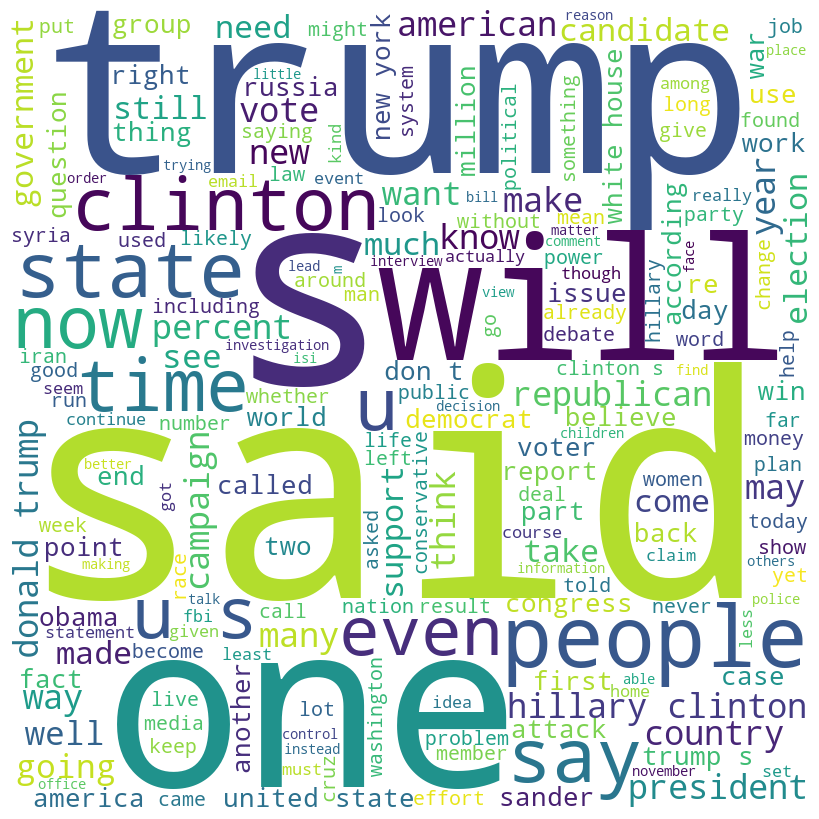

In [49]:
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in fake_or_real_news['text']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

#### Check lable disribution

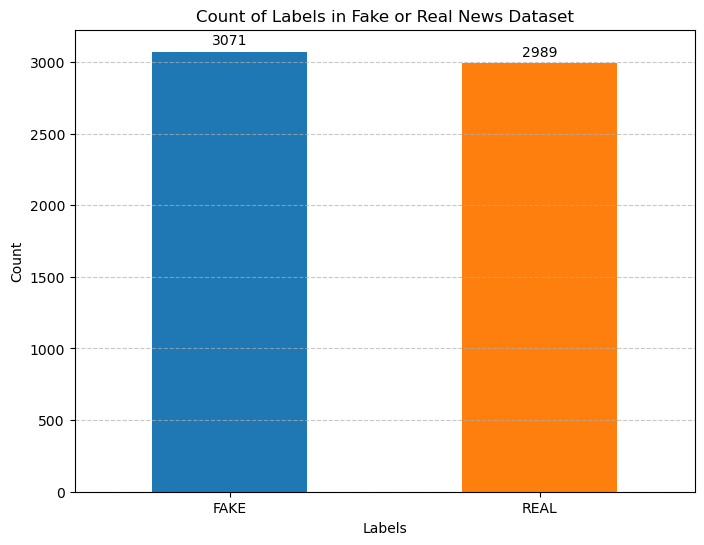

In [50]:
def plot_label(data, title='Count Labels'):
    """
    a bar chart of label counts for different data to check if the data is balanced or not.
    
    Parameters:
        dataset (DataFrame): The dataset containing the column to plot.
        column_name (str): The column to count and visualize.
        title (str): The title of the chart. Default is 'Count of Labels'.
        colors (list): A list of colors for the bars. Default is None.
    """
    # Count the occurrences of each label
    label_counts = data['label'].value_counts()
    
    # Dynamically generate colors based on the number of unique labels
    num_labels = label_counts.shape[0]
    colors = cm.tab10.colors[:num_labels]  
    
    # Plot the bar chart
    plt.figure(figsize=(8, 6))
    ax = label_counts.plot(kind='bar', color=colors)
    
    # Add annotations (numbers on bars)
    for i, count in enumerate(label_counts):
        plt.text(i, count + max(label_counts) * 0.01, str(count), ha='center', va='bottom', fontsize=10)
    
    # Customize the chart
    plt.title(title)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_label(fake_or_real_news, title='Count of Labels in Fake or Real News Dataset')

#### Word count

In [51]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

fake_or_real_news['word_count'] = fake_or_real_news['text'].apply(word_count)

#### Word length

In [52]:
fake_or_real_news['length'] = fake_or_real_news['text'].str.len()

#### Mean word length

In [53]:
fake_or_real_news['mean_word_length'] = fake_or_real_news['text'].map(lambda rev: np.mean([len(word) for word in tokenize.sent_tokenize(rev)]))

/home/see/anaconda3/envs/tf3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/see/anaconda3/envs/tf3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


#### Mean sentence length

In [54]:
fake_or_real_news['mean_sentence_length'] = np.mean([len(sent) for sent in tokenize.sent_tokenize(fake_or_real_news['text'][0])])

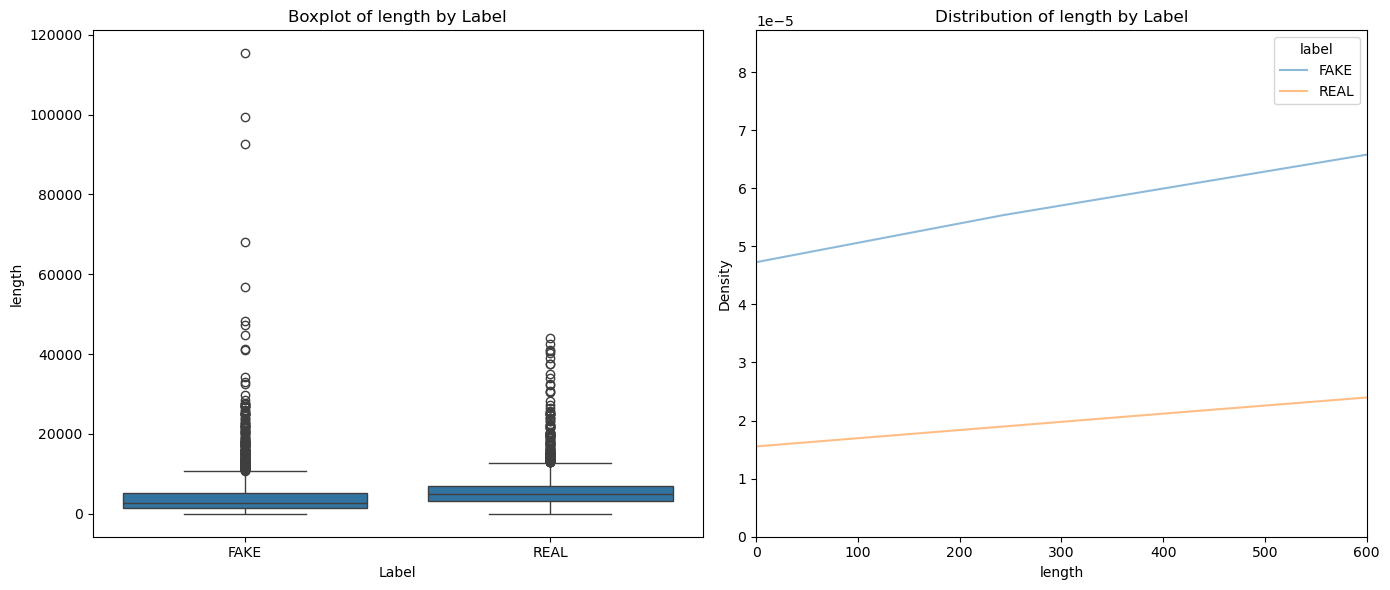

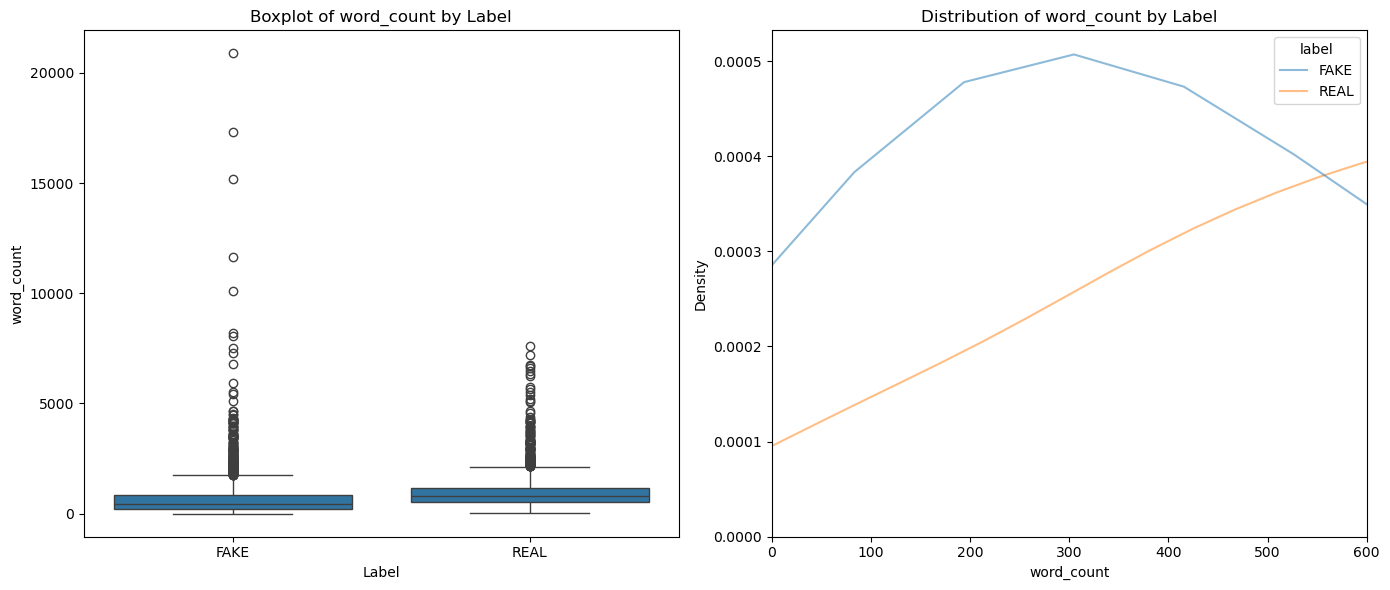

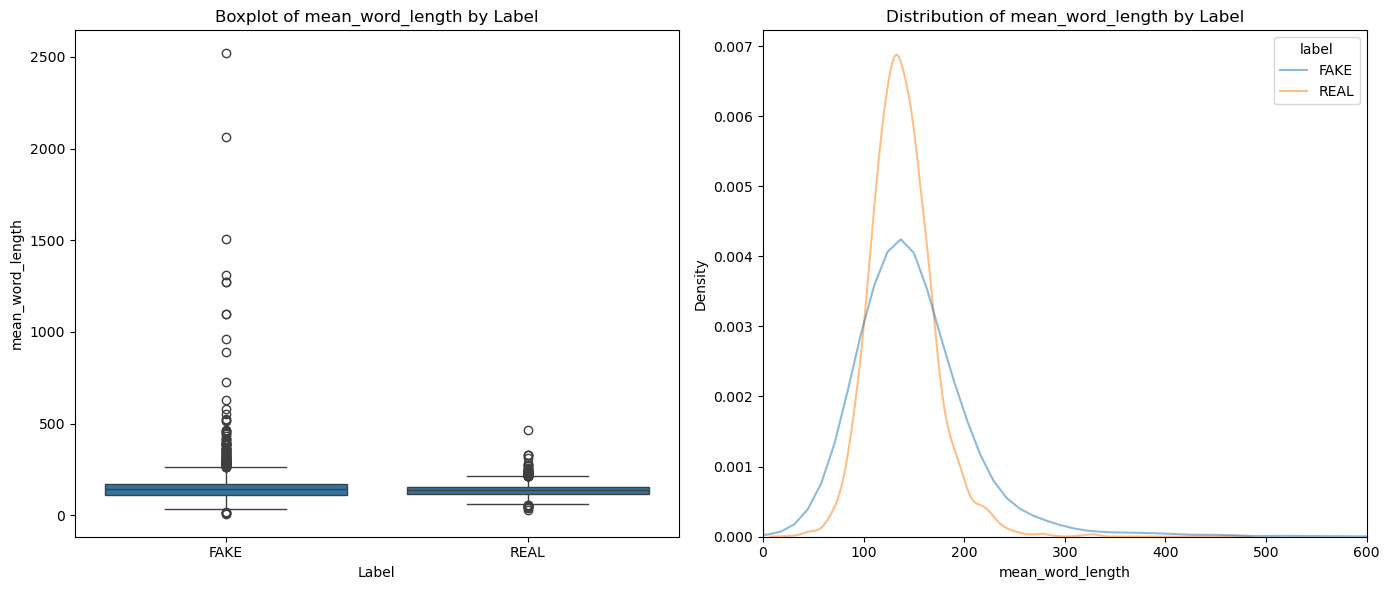

/tmp/ipykernel_179414/3765156333.py:20: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=col, hue='label', fill=False, alpha=0.5)


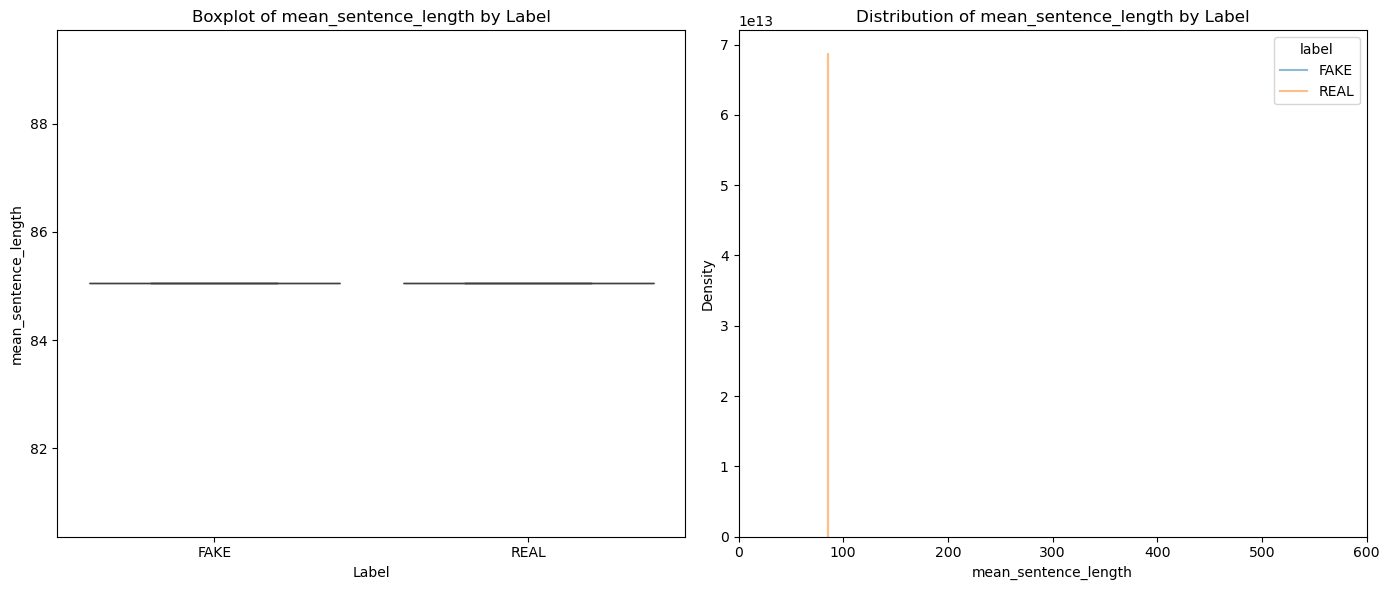

In [55]:
def visualize(col, data, xlim=None):
    """
    Visualizes the distribution and boxplot of a given column based on the 'label'.
    
    Parameters:
    col (str): Column name to visualize.
    """
    # Create a figure for side-by-side subplots
    plt.figure(figsize=(14, 6))
    
    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(y=data[col], x=data['label'])
    plt.title(f'Boxplot of {col} by Label')
    plt.xlabel('Label')
    plt.ylabel(col)
    
    # KDE plot
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=data, x=col, hue='label', fill=False, alpha=0.5)
    plt.title(f'Distribution of {col} by Label')
    plt.xlabel(col)
    plt.ylabel('Density')

     # Adjust x-axis range if specified
    if xlim:
        plt.xlim(xlim)
    
    # Show the plots
    plt.tight_layout()
    plt.show()

# Define the features (ensure these are column names)
features = ['length', 'word_count', 'mean_word_length', 'mean_sentence_length']  # Replace with actual column names from your dataset

# Iterate through features and visualize
for feature in features:
    visualize(feature, fake_or_real_news, xlim=(0, 600))


# Pre-Processing


In [56]:
def clean_texts(df_column):
    """
    Clean the text data by removing stopwords, punctuation, tokennize and special characters.
    
    Parameters:
        df_column (str): The text data to clean.
    
    Returns:
        The cleaned text data.
    """

    # expand U.S. 
    df_column = df_column.replace("U.S.", "UnitedStates")
    df_column = df_column.replace("u.s.", "UnitedStates")

    # remove punctuation
    df_column = re.sub(r'[^\w\s]', ' ', df_column)

    # remove special characters
    df_column = re.sub(r'[^\x00-\x7F]+', ' ', df_column)

    # remove extra spaces
    df_column = re.sub(r'\s+', ' ', df_column)

    # contatact numbers toghther 
    df_column = re.sub(r'(\d+)\s+(\d+)', r'\1\2', df_column)

    # remove non-alphabetic characters
    df_column = re.sub(r'[^a-zA-Z]', ' ', df_column)

    # tokenize
    df_column = word_tokenize(df_column)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    df_column = [word for word in df_column if word.lower() not in stop_words]

    # lemmatize
    lemmatizer = WordNetLemmatizer()
    df_column = [lemmatizer.lemmatize(word) for word in df_column]
    

    return " ".join(df_column).lower()


In [57]:
# fake_or_real_news data
# fake_or_real_news['cleaned_text'] = fake_or_real_news['text'].apply(clean_texts)

# the file has excuted in transformer file and exported to csv fiile, so it can be readed here, just to save time
fake_or_real_news = pd.read_csv("/mnt/c/Users/seesu/Desktop/New folder (4)/Individual/cleaned_news.csv")

# drop na values 
fake_or_real_news = fake_or_real_news.dropna(subset=['cleaned_text'])

#### Word embeddings: word2vec
https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook

In [58]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [69]:
# create a list of sentences from the cleaned text
sentense_list = [row.split() for row in fake_or_real_news['cleaned_text']]

# create the relevant phrases from the list of sentences
phrases = Phrases(sentense_list, min_count=30, progress_per=10000)

bigram = Phraser(phrases)

# transform the corpus based on the bigrams detected
sentences = bigram[sentense_list]

# the most 10 frequent words
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

# create the word2vec model
w2v_model = Word2Vec(min_count=20,# ignore all words with total frequency lower than 20
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=5)

# create vocabulary table from tokenized sentences
w2v_model.build_vocab(sentences, progress_per=10000)

# train the word2vec model using the tokenized sentences and bigrams transformed sentences
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

# create the embedding matrix
word_indices = {word: idx + 1 for idx, word in enumerate(w2v_model.wv.index_to_key)}
vocab_size = len(word_indices) + 1
embedding_dim = w2v_model.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in word_indices.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]

print("Embedding Matrix Shape:", embedding_matrix.shape)

2025-01-31 19:27:18,893 : INFO : collecting all words and their counts
2025-01-31 19:27:18,894 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2025-01-31 19:27:21,901 : INFO : collected 1574632 token types (unigram + bigrams) from a corpus of 2719411 words and 6058 sentences
2025-01-31 19:27:21,902 : INFO : merged Phrases<1574632 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
2025-01-31 19:27:21,906 : INFO : Phrases lifecycle event {'msg': 'built Phrases<1574632 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 3.01s', 'datetime': '2025-01-31T19:27:21.905938', 'gensim': '4.3.3', 'python': '3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'created'}
2025-01-31 19:27:21,906 : INFO : exporting phrases from Phrases<1574632 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
2025-01-31 19:27:25,017 : INFO : Frozen

Embedding Matrix Shape: (12437, 300)


In [70]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['said',
 'trump',
 'would',
 'one',
 'clinton',
 'people',
 'state',
 'also',
 'time',
 'say']

#### Pad sequences

In [71]:
X = fake_or_real_news['cleaned_text']
y = fake_or_real_news['label']

tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(X)

# convert the text to sequences
X_sequences = tokenizer.texts_to_sequences(X)

# pad the sequences
X_padded = pad_sequences(X_sequences, maxlen=500)

#### Data Spliting and label encoding

In [72]:
# encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

In [73]:
# check the shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4846, 500)
y_train shape: (4846,)
X_test shape: (1212, 500)
y_test shape: (1212,)


# Model

In [74]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [75]:
# set parameters 
embedding_dim = 300
maxlen = 500
num_classes = len(label_encoder.classes_)

## GRU + CNN
https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

In [76]:
# set the learning rate 
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

# set the optimizer
optimizer = Adam(learning_rate=lr_schedule)

# set the vocabulary size
vocab_size = embedding_matrix.shape[0]

# create the model
gru_model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),

    # CNN + MaxPooling
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),

    # GRU Units + Regularization
    Bidirectional(GRU(32, return_sequences=False, kernel_regularizer=l2(0.002))),
    Dropout(0.5),

    Dense(128, activation='relu', kernel_regularizer=l2(0.002)),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

# Compile
gru_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Early Stopping 
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# Train Model
gru_history = gru_model.fit(
    X_train, y_train, 
    validation_split=0.2, 
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

# evalute the model
test_loss, test_acc = gru_model.evaluate(X_test, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

I0000 00:00:1738348155.367897  179414 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/20


I0000 00:00:1738348159.361973  184686 cuda_dnn.cc:529] Loaded cuDNN version 90300


122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.5678 - loss: 1.2086 - val_accuracy: 0.7000 - val_loss: 0.8747
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7453 - loss: 0.8077 - val_accuracy: 0.7381 - val_loss: 0.7014
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8557 - loss: 0.5518 - val_accuracy: 0.7588 - val_loss: 0.7005
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9236 - loss: 0.3698 - val_accuracy: 0.7495 - val_loss: 0.7020
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9640 - loss: 0.2583 - val_accuracy: 0.7639 - val_loss: 0.8701
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9851 - loss: 0.1876 - val_accuracy: 0.7433 - val_loss: 0.9770
test loss and accuracy: 0.6963140368461609 0.7648515105247498


## RNN + LSTM
https://www.kaggle.com/code/avikumart/nlp-news-articles-classif-wordembeddings-rnn

In [77]:
# For CuDNNLSTM (depending on TF version):
# If you are using TF 1.x or tf.compat.v1 in TF 2.x:


# Otherwise (TF 2.x might not have a dedicated CuDNNLSTM in tf.keras.layers):
# from tensorflow.keras.layers import LSTM
# (This LSTM will use CuDNN if GPU is available and dropout is disabled)
word_indices = tokenizer.word_index
vocab_size = len(word_indices) + 1  

rnn_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=maxlen
    ),
     Bidirectional(LSTM(64, return_sequences=True)), 

    Bidirectional(LSTM(128, return_sequences=False)),  

    Dropout(0.3),
    
    # dense layer with L2 regularization
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dropout(0.4),
    
    # output layer
    Dense(num_classes, activation='softmax')
])

# build model
rnn_model.build(input_shape=(None, maxlen))

rnn_model.summary()

# compile model 
rnn_model.compile(
    optimizer=Adam(learning_rate=0.001, clipvalue=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    verbose = 1,
    restore_best_weights=True
)

# train the model
rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# evaluate the model on the test set
loss, accuracy = rnn_model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


/home/see/anaconda3/envs/tf3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 500, 300)       │    18,295,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 500, 128)       │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,762,426 (71.57 MB)

 Trainable params: 18,762,426 (71.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.6251 - loss: 6.0130 - val_accuracy: 0.7970 - val_loss: 0.6509
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 0.8579 - loss: 0.4680 - val_accuracy: 0.8845 - val_loss: 0.3323
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.9236 - loss: 0.2538 - val_accuracy: 0.8903 - val_loss: 0.3090
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - accuracy: 0.9513 - loss: 0.1884 - val_accuracy: 0.8878 - val_loss: 0.3662
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9632 - loss: 0.1569 - val_accuracy: 0.8969 - val_loss: 0.3135
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 0.9680 - loss: 0.1440 - val_accuracy: 0.8870 - val_loss: 0.3554
Epoch 7/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9793 - loss: 0.1056 - val_accuracy: 0.8944 - val_loss: 0.3698
Epoch 8/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.9841 - loss: 0

# Evaluation

In [78]:
def plot_confusion_matrix(y_true, y_pred, labels=None, normalize=False, title="Confusion Matrix"):
    """
    Plots a confusion matrix.

    Parameters:
    - y_true: array-like of shape (n_samples,)
      True labels.
    - y_pred: array-like of shape (n_samples,)
      Predicted labels.
    - labels: list, optional
      Class labels. If None, inferred from y_true.
    - normalize: bool, default=False
      If True, normalize the confusion matrix.
    - title: str, default="Confusion Matrix"
      Title of the plot.

    Returns:
    - None (Displays the plot)
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="YlOrRd", xticklabels=['Fake (0)', 'Real (1)'], yticklabels=['Fake (0)', 'Real (1)'])
    
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


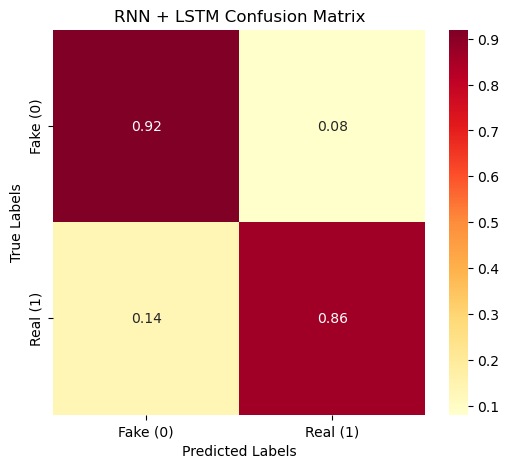

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       595
           1       0.92      0.86      0.89       617

    accuracy                           0.89      1212
   macro avg       0.89      0.89      0.89      1212
weighted avg       0.89      0.89      0.89      1212



In [79]:
# RNN Model
y_pred_probs = rnn_model.predict(X_test)  
y_pred = np.argmax(y_pred_probs, axis=1) 

labels = sorted(set(y_test) | set(y_pred))

plot_confusion_matrix(y_test, y_pred, labels=labels, normalize=True, title="RNN + LSTM Confusion Matrix")


print(classification_report(y_test, y_pred))

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


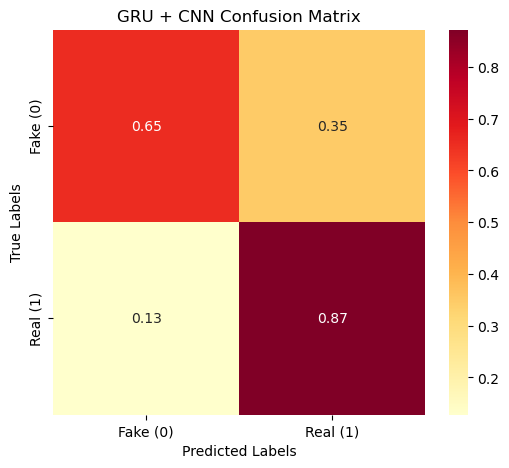

In [80]:
# GRU Model
y_pred_probs = gru_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

labels = sorted(set(y_test) | set(y_pred))

plot_confusion_matrix(y_test, y_pred, labels=labels, normalize=True, title="GRU + CNN Confusion Matrix")

In [81]:
def plot_loss_accuracy(history, model_name):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1, len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'r', label='Training acc')  # Changed to red
    plt.plot(epochs, val_acc, 'g', label='Validation acc')  # Changed to green
    plt.title("Training and validation accuracy " + model_name, fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'm', label='Training loss')  # Changed to magenta
    plt.plot(epochs, val_loss, 'c', label='Validation loss')  # Changed to cyan
    plt.title("Training and validation loss " + model_name, fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

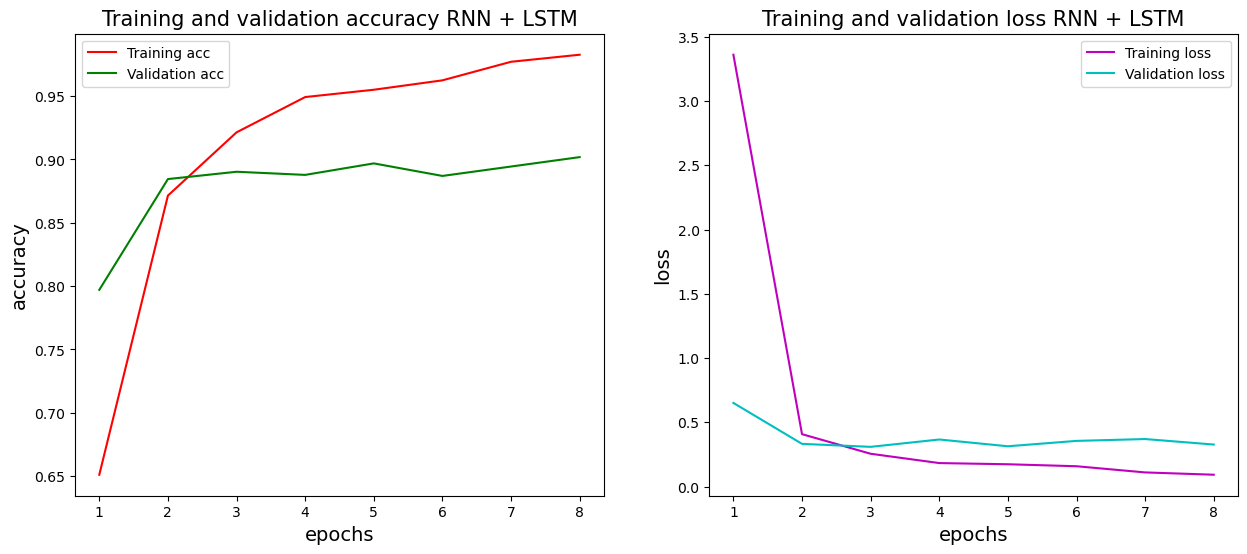

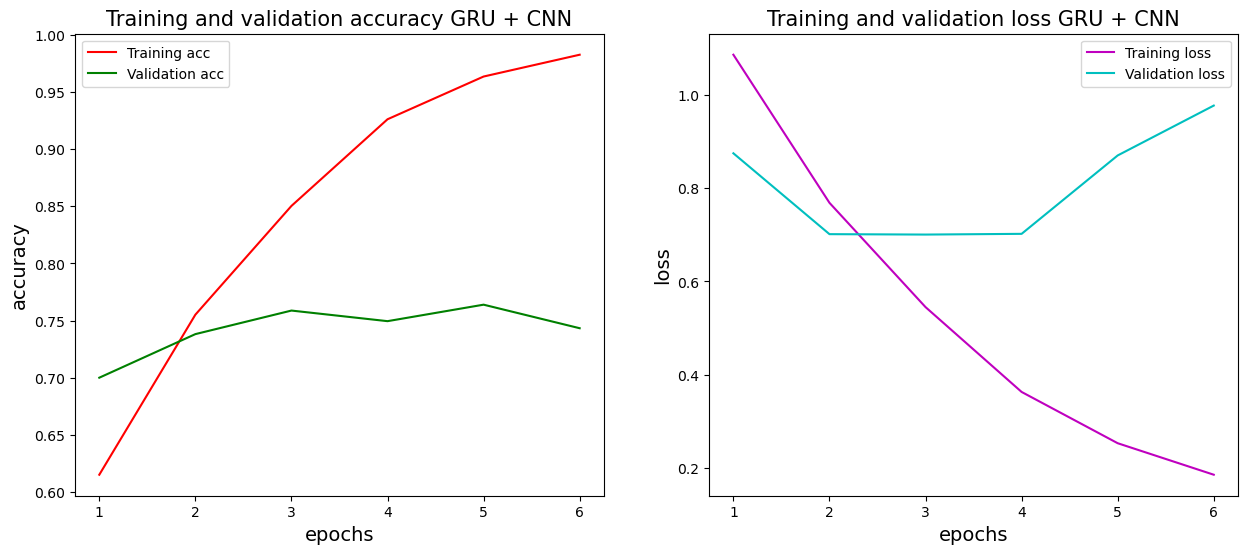

In [82]:
plot_loss_accuracy(rnn_history, 'RNN + LSTM')
plot_loss_accuracy(gru_history, 'GRU + CNN')